In [45]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # Python is not happy about my loc statement in "label_stores"

##### Assumptions

- Test period should end on 2017-02-11: 90 days before and 90 days after

##### Read in the Data and Filter

In [2]:
products = pd.read_csv(f"/home/adam/Documents/JobApplications/MarketDial/marketdial_ds_takehome/products_of_interest.csv", header=None)
stores = pd.read_csv(f"/home/adam/Documents/JobApplications/MarketDial/marketdial_ds_takehome/store_attributes.csv", usecols=list(range(1, 7)))
transactions = pd.read_csv(f"/home/adam/Documents/JobApplications/MarketDial/marketdial_ds_takehome/transactions.csv", usecols=list(range(1, 6)))

treatment_stores = pd.read_csv(f"/home/adam/Documents/JobApplications/MarketDial/marketdial_ds_takehome/q3_treatment_stores.csv", header=None, names=["treatment"])
control_stores = pd.read_csv(f"/home/adam/Documents/JobApplications/MarketDial/marketdial_ds_takehome/q3_control_stores.csv", header=None, names=["control"])
products_of_interest = pd.read_csv(f"/home/adam/Documents/JobApplications/MarketDial/marketdial_ds_takehome/products_of_interest.csv", header=None, names=["products"])

In [3]:
# Convert to datetime
transactions['date_week'] = pd.to_datetime(transactions['date_week'])

In [4]:
# Check relevance of column
transactions['currency_code'].unique()

# Drop column
transactions.drop(columns=['currency_code'], inplace=True)

In [5]:
# Identify stores of interest
stores_of_interest = pd.concat([treatment_stores["treatment"], control_stores["control"]]).values

# Define dates of interest
pre_start, pre_stop = np.datetime64('2016-07-17'), np.datetime64('2016-10-09')
post_start, post_stop = np.datetime64('2016-11-13'), np.datetime64('2017-02-05')

# Filter transactions
pre_transactions = transactions[transactions['store_id'].isin(stores_of_interest) &
                                transactions['date_week'].between(pre_start, pre_stop) &
                                transactions['product_id'].isin(products_of_interest['products'])]

post_transactions = transactions[transactions['store_id'].isin(stores_of_interest) &
                                transactions['date_week'].between(post_start, post_stop) &
                                transactions['product_id'].isin(products_of_interest['products'])]

In [52]:
# Create helper functions for processing
def label_stores(df, treatment_stores_df, control_stores_df):
    '''Create a "group" column to label which records are treatment vs control group'''
    
    df.loc[df['store_id'].isin(treatment_stores_df['treatment']), 'group'] = 'treatment'
    df.loc[df['store_id'].isin(control_stores_df['control']), 'group'] = 'control'
    
def aggregate_products(df):
    '''Aggregate the revenue for each store-week to account for all products of interest'''
#     return df.groupby(['date_week', 'store_id', 'group'])['revenue'].agg(sum).reset_index()
    return df.groupby(['date_week', 'group'])['revenue'].agg(sum).reset_index()


def split_stores(df):
    '''Split a dataframe into two dataframes containing treatment records and control records'''
    control = df[df['group'] == 'control']
    treatment = df[df['group'] == 'treatment']
    
    return (treatment, control)

def process_dataframe(df, treatment_stores_df, control_stores_df):
    '''Calling function to control label_stores, aggregate_products, split_stores'''
    label_stores(df, treatment_stores_df, control_stores_df)
    aggregated = aggregate_products(df)
    return split_stores(aggregated)
    

In [53]:
# Process the data
pre_treatment, pre_control = process_dataframe(pre_transactions, treatment_stores, control_stores)
post_treatment, post_control = process_dataframe(post_transactions, treatment_stores, control_stores)

##### Visualize

[Text(0.5, 1.0, 'Experiment Sales')]

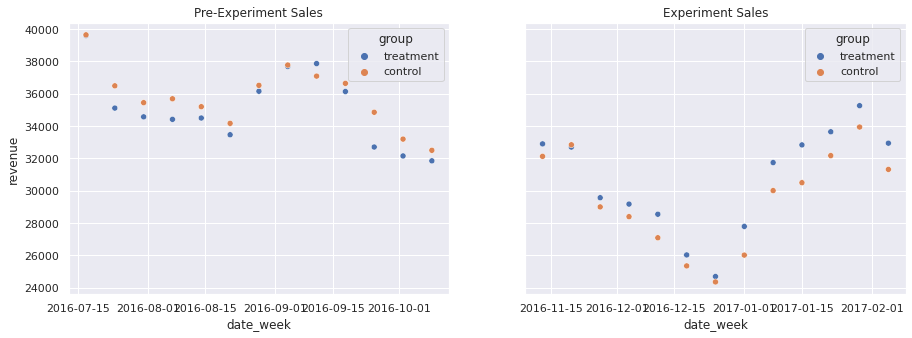

In [90]:
# Create Datasets
pre_data = pd.concat([pre_treatment, pre_control])
post_data = pd.concat([post_treatment, post_control])

# Plot pre-experiment vs experiment results
sns.set(rc={'figure.figsize':(15,5)})
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot(x='date_week', y='revenue', hue='group', data=pre_data, ax=ax1).set(title="Pre-Experiment Sales")
sns.scatterplot(x='date_week', y='revenue', hue='group', data=post_data, ax=ax2).set(title="Experiment Sales")

##### Check Significance

In [108]:
def get_revenue_delta(treatment, control):
    '''Accepts two dataframes and returns a single dataframe containing the revenue difference between
    the control and treatment datasets, by week'''
    
    treatment = treatment.rename(columns={'revenue':'treatment_revenue'})
    control = control.rename(columns={'revenue': 'control_revenue'})
    
    delta = treatment.merge(control, on='date_week', how='inner')
    delta['rev_delta'] = delta['control_revenue'] - delta['treatment_revenue']
    return delta[['date_week', 'rev_delta']]
    

In [109]:
# Compare differences between treatment and control during experiment vs pre-exeriment
pre_delta = get_revenue_delta(pre_treatment, pre_control)
post_delta = get_revenue_delta(post_treatment, post_control)

In [110]:
# Run a t-test to compare rev_deltas pre vs post experiment
stats.ttest_rel(pre_delta['rev_delta'], post_delta['rev_delta']) # p-value indicates that the means are different

Ttest_relResult(statistic=7.737600109081109, pvalue=5.2811454153542286e-06)

In [127]:
def get_sample_stats(df):
    n = len(df)
    mean = df['rev_delta'].mean()
    std = np.std(df['rev_delta'], ddof=1)
    
    return n, mean, std

def get_ste_estimate(n1, n2, s1, s2):
    numerator = (n1-1)*s1**2 + (n2-1)*s2**2
    denominator = n1+n2-2
    pooled_std = np.sqrt(numerator/denominator)
    
    weights = np.sqrt((1/n1)+(1/n2))
    return pooled_std*weights

In [134]:
pre_n, pre_mean, pre_std = get_sample_stats(pre_delta)
post_n, post_mean, post_std = get_sample_stats(post_delta)

ste = get_ste_estimate(pre_n, post_n, pre_std, post_std)

t = 2.064 # 95% CI with (13+13-2)=24 dof

In [137]:
UB = (pre_mean - post_mean) + t*ste
LB = (pre_mean - post_mean) - t*ste

In [139]:
print("Pre-mean", pre_mean)
print("Post-mean", post_mean)
print("Delta point estimate", (pre_mean-post_mean))
print("Estimated Standard Error", ste)
print("Lower Bound Estimate (95% CI)", LB)
print("Upper Bount Estimate (95% CI)", UB)

Pre-mean 691.14
Post-mean -1130.3569230769224
Delta point estimate 1821.4969230769225
Estimated Standard Error 276.341797817496
Lower Bound Estimate (95% CI) 1251.1274523816107
Upper Bount Estimate (95% CI) 2391.866393772234


##### Summary

- Prior to the experiment, the combined stores in the control group averaged $691.14 more revenue per week than the treatment group

- During the experiment, they averaged $1130.35 less revenue per week (i.e. \\$1821.49 drop)

- This delta is statistically significant (i.e. very unlikely due to random fluctuation)

- The recommendation is not to roll out the change